# Report: Ex1 - ZooScanNet in the cloud

## Tore Aadland

Prior works:
http://benanne.github.io/2015/03/17/plankton.html
https://www.kaggle.com/c/datasciencebowl/discussion

First lets load required modules:

In [5]:
import numpy as np
import random as rn
from dotenv import load_dotenv
import os
from skimage import io
from skimage.transform import resize, rotate
from skimage.util import pad
import matplotlib.pyplot as plt
from keras.utils import to_categorical, plot_model, Sequence

import itertools

from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout
from keras.layers import Dropout, Flatten, Dense, Input, Concatenate, Reshape, Flatten
from keras.applications.inception_v3 import InceptionV3
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from sklearn.metrics import confusion_matrix
from keras import backend
# import tensorflow as tf

import datetime
import time
import threading
load_dotenv()

Using TensorFlow backend.


True

Then load environmental variables that point to the location of folders on this instance.

In [6]:
datafolder = os.getenv("DATAFOLDER")
outputfolder = os.getenv("OUTPUTFOLDER")
imgfolder = os.path.join(datafolder, 'MiniZoo','imgs')
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

I am unhappy about the rigidity of the default ImageDataGenerator. I need some way of propagating the size of the image to the neural network, and I need to have a good solution for dealing with class imbalance. I make my own custom data generator.

In [7]:
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

def elastic_transform(image, alpha, sigma, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_.
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
       Convolutional Neural Networks applied to Visual Document Analysis", in
       Proc. of the International Conference on Document Analysis and
       Recognition, 2003.
    """
    assert len(image.shape)==2

    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha

    x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')
    indices = np.reshape(x+dx, (-1, 1)), np.reshape(y+dy, (-1, 1))
    
    return map_coordinates(image, indices, order=1).reshape(shape)

def add_noise(data):
    # From: https://stackoverflow.com/questions/22937589/how-to-add-noise-gaussian-salt-and-pepper-etc-to-image-in-python-with-opencv?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa
    noisetype = "gauss" #np.random.choice(["none", "gauss", "sandp"])
    if  noisetype == "none":
        return data
    elif noisetype == "gauss":
        row,col= data.shape
        mean = data.mean()
        sigma = data.std()*np.random.random()*0.25
        gauss = np.random.normal(mean,sigma,(row,col))
        gauss = gauss.reshape(row,col)
        noisy = data + gauss
        return noisy
    elif noisetype == "sandp":
        M, N = data.shape
        s_vs_p = 0.5
        amount = 0.1
        out = np.copy(data)
        std = data.std()
        # Salt mode
        num_salt = np.ceil(amount * data.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
            for i in data.shape]
        out[coords] += std

        # Pepper mode
        num_pepper = np.ceil(amount* data.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
            for i in data.shape]
        out[coords] -= std

        return out


class MySequence(Sequence):
    def __init__(self, batch_size, label_paths, images, get_statistics, augment_image, number_labels, size, get_label_and_image, val_split, test_split):
        self.batch_size = batch_size
        self.label_paths = label_paths
        self.images = images
        self.get_statistics = get_statistics
        self.augment_image = augment_image
        self.number_labels = number_labels
        self.size = size
        self.get_label_and_image = get_label_and_image
        self.val_split = val_split
        self.test_split = test_split
        self.seeded = False
        
    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        if not self.seeded:
            rn.seed(int(time.time()*10000000)%1000000007)
            np.random.seed(int(time.time()*10000000)%1000000007)
            self.seeded=True
        output_list = []
        output_labels = []
        lab_img = self.get_label_and_image(idx)
        for random_label, random_image in lab_img:
            output_labels.append(random_label)
            output_list.append(os.path.join(self.label_paths[random_label], self.images[random_label][random_image]))
        output_images = [1-io.imread(fp) for fp in output_list]
        output_statistics = [self.get_statistics(image) for image in output_images]
        output_augmented_images = [self.augment_image(image).reshape(224,224,1) for image in output_images]
        return ([np.stack(output_augmented_images), 
              np.stack(output_statistics)], 
              to_categorical(np.stack(output_labels), num_classes = self.number_labels))

class MyGenerators(object):
    def __init__(self, path, val_fac=0.1, batch_size=16, validation_size=64, target_size=(224,224)):
        self.path = path
        self.val_fac = val_fac
        self.batch_size = batch_size
        self.validation_size = validation_size
        self.target_size = target_size
        
        self.labels = os.listdir(path)
        self.number_labels = len(self.labels)
        self.number_label_elements = {}
        self.label_paths = {}
        self.label_len = {}
        self.images = {}
        self.labels_to_classify = []
        for i, l in enumerate(self.labels):
            self.label_paths[i] = os.path.join(self.path, l)
            self.images[i] = (os.listdir(self.label_paths[i]))
            self.label_len[i] = len(self.images[i])
        self.test_split = int(val_fac*min(self.label_len.values()))
        self.val_split = int(2*val_fac*min(self.label_len.values()))
        self.val_steps = int(self.number_labels*(self.val_split-self.test_split)/self.batch_size)
        self.val_log = []
        self.training_log = []

    def make_square(self, image, mode='constant'):
        if max(image.shape) > 224:
            max_dim = max(image.shape)
            pads = ((int((max_dim-image.shape[0])/2),
                   int((max_dim-image.shape[0])/2)),
                   (int((max_dim-image.shape[1])/2),
                   int((max_dim-image.shape[1])/2)))
            if (mode=='constant'):
                image = pad(image,pads , mode=mode, constant_values=0)
            else:
                image = pad(image,pads , mode=mode)
            return resize(image, (224,224), mode=mode, anti_aliasing=False)
        else:
            max_dim = 224
            pads = ((int((max_dim-image.shape[0])/2),
                   int((max_dim-image.shape[0])/2)),
                   (int((max_dim-image.shape[1])/2),
                   int((max_dim-image.shape[1])/2)))
            if (mode=='constant'):
                image = pad(image,pads , mode=mode, constant_values=0)
            else:
                image = pad(image, pads , mode=mode)
            return resize(image, (224,224), mode=mode, anti_aliasing=False)
        
    def augment_image(self, image):
        if(np.random.choice([True, False])):
            image = np.flip(image, axis=1)
        max_dim = max(image.shape)
        angle = np.random.randint(0, 359 + 1)
        image = rotate(image, angle, resize=True, mode='constant', cval=0)
        image = self.make_square(image, mode='constant')
        #image = elastic_transform(image, 224, np.random.randint(17,22))#19 
        #image = add_noise(image)
        return image

    def get_statistics(self, image):
        return (max(image.shape)/1024.0, min(image.shape)/1024.0, np.sum(image==255)/(1.0*np.product(image.shape)))

    def base_generator(self, augment_image, get_random_label_and_image):
        output_list = []
        output_labels = []
        while not len(output_list) == self.batch_size:
            random_label, random_image = next(get_random_label_and_image)
            output_labels.append(random_label)
            output_list.append(os.path.join(self.label_paths[random_label], self.images[random_label][random_image]))
        output_images = [1-io.imread(fp) for fp in output_list]
        output_statistics = [self.get_statistics(image) for image in output_images]
        output_augmented_images = [augment_image(image).reshape(224,224,1) for image in output_images]
        return ([np.stack(output_augmented_images), 
              np.stack(output_statistics)], 
              to_categorical(np.stack(output_labels), num_classes = self.number_labels))

    def training_image_selector(self, idx):
        lab_img = []
        for i in range(self.batch_size):
            label = np.random.choice(self.number_labels)
            random_image = np.random.choice(range(self.val_split, self.label_len[label]))
            lab_img.append((label, random_image))
        return lab_img
    
    def training_generator(self):
        return MySequence(batch_size=self.batch_size, 
                          label_paths=self.label_paths, 
                          images = self.images,
                          get_statistics=self.get_statistics, 
                          augment_image=self.augment_image, 
                          number_labels=self.number_labels, 
                          size=int(self.number_labels*(min(self.label_len.values()) - self.val_split)/self.batch_size), 
                          get_label_and_image=self.training_image_selector, 
                          val_split=self.val_split, 
                          test_split=self.test_split)

    def val_image_selector(self, idx):
        lab_img = []
        for i in range(idx * self.batch_size, (idx + 1) * self.batch_size):
            num_img_per_label = self.val_split-self.test_split
            i = i % int(self.number_labels*(num_img_per_label))
            lab = int(i/num_img_per_label)
            img = i - lab*num_img_per_label
            lab_img.append((lab, img+self.test_split))
        return lab_img

    
    def validation_generator(self):
        return MySequence(batch_size=self.batch_size, 
                          label_paths=self.label_paths,
                          get_statistics=self.get_statistics, 
                          images = self.images,
                          augment_image=self.make_square, 
                          number_labels=self.number_labels, 
                          size=int(self.number_labels*(self.val_split-self.test_split)/self.batch_size), 
                          get_label_and_image=self.val_image_selector, 
                          val_split=self.val_split, 
                          test_split=self.test_split)


class MySecondGenerators(MyGenerators):
    def make_square(self, image, mode='symmetric'):
        if max(image.shape) > 224:
            max_dim = max(image.shape)
            pads = ((int((max_dim-image.shape[0])/2),
                   int((max_dim-image.shape[0])/2)),
                   (int((max_dim-image.shape[1])/2),
                   int((max_dim-image.shape[1])/2)))
            if (mode=='constant'):
                image = pad(image,pads , mode=mode, constant_values=0)
            else:
                image = pad(image,pads , mode=mode)
            return resize(image, (224,224), mode=mode)
        else:
            max_dim = 224
            pads = ((int((max_dim-image.shape[0])/2),
                   int((max_dim-image.shape[0])/2)),
                   (int((max_dim-image.shape[1])/2),
                   int((max_dim-image.shape[1])/2)))
            if (mode=='constant'):
                image = pad(image,pads , mode=mode, constant_values=0)
            else:
                image = pad(image, pads , mode=mode)
            return resize(image, (224,224), mode=mode)
        
    def augment_image(self, image):
        if(np.random.choice([True, False])):
            image = np.flip(image, axis=1)
        max_dim = max(image.shape)
        angle = np.random.choice([0,np.random.randint(0, 359 + 1)])
        image = rotate(image, angle, resize=True, mode='constant', cval=0)
        image = self.make_square(image, mode='symmetric')
        #if(np.random.choice([True, False])):
        #    image = elastic_transform(image, 224, 19)
        return image
            
class MyImageSequence(Sequence):
    def __init__(self, batch_size, label_paths, images, get_statistics, augment_image, number_labels, size, get_label_and_image, val_split, test_split):
        self.batch_size = batch_size
        self.label_paths = label_paths
        self.images = images
        self.get_statistics = get_statistics
        self.augment_image = augment_image
        self.number_labels = number_labels
        self.size = size
        self.get_label_and_image = get_label_and_image
        self.val_split = val_split
        self.test_split = test_split
        self.seeded = False
        
    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        if not self.seeded:
            rn.seed(int(time.time()*10000000)%1000000007)
            np.random.seed(int(time.time()*10000000)%1000000007)
            self.seeded=True
        output_list = []
        output_labels = []
        lab_img = self.get_label_and_image(idx)
        for random_label, random_image in lab_img:
            output_labels.append(random_label)
            output_list.append(os.path.join(self.label_paths[random_label], self.images[random_label][random_image]))
        output_images = [1-io.imread(fp) for fp in output_list]
        output_augmented_images = [self.augment_image(image).reshape(224,224,1) for image in output_images]
        return (np.stack(output_augmented_images), 
              to_categorical(np.stack(output_labels), num_classes = self.number_labels))

class MyImageGenerators(MyGenerators):
    def training_generator(self):
        return MyImageSequence(batch_size=self.batch_size, 
                          label_paths=self.label_paths, 
                          images = self.images,
                          get_statistics=self.get_statistics, 
                          augment_image=self.augment_image, 
                          number_labels=self.number_labels, 
                          size=int(self.number_labels*(min(self.label_len.values()) - self.val_split)/self.batch_size), 
                          get_label_and_image=self.training_image_selector, 
                          val_split=self.val_split, 
                          test_split=self.test_split) 
    
    def validation_generator(self):
        return MyImageSequence(batch_size=self.batch_size, 
                          label_paths=self.label_paths,
                          get_statistics=self.get_statistics, 
                          images = self.images,
                          augment_image=self.make_square, 
                          number_labels=self.number_labels, 
                          size=int(self.number_labels*(self.val_split-self.test_split)/self.batch_size), 
                          get_label_and_image=self.val_image_selector, 
                          val_split=self.val_split, 
                          test_split=self.test_split)


class MyStatSequence(Sequence):
    def __init__(self, batch_size, label_paths, images, get_statistics, augment_image, number_labels, size, get_label_and_image, val_split, test_split):
        self.batch_size = batch_size
        self.label_paths = label_paths
        self.images = images
        self.get_statistics = get_statistics
        self.augment_image = augment_image
        self.number_labels = number_labels
        self.size = size
        self.get_label_and_image = get_label_and_image
        self.val_split = val_split
        self.test_split = test_split
        self.seeded = False
        
    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        if not self.seeded:
            rn.seed(int(time.time()*10000000)%1000000007)
            np.random.seed(int(time.time()*10000000)%1000000007)
            self.seeded=True
        output_list = []
        output_labels = []
        lab_img = self.get_label_and_image(idx)
        for random_label, random_image in lab_img:
            output_labels.append(random_label)
            output_list.append(os.path.join(self.label_paths[random_label], self.images[random_label][random_image]))
        output_images = [1-io.imread(fp) for fp in output_list]
        output_statistics = [self.get_statistics(image) for image in output_images]
        return (np.stack(output_statistics), 
              to_categorical(np.stack(output_labels), num_classes = self.number_labels))

class MyStatGenerators(MyGenerators):
    def training_generator(self):
        return MyStatSequence(batch_size=self.batch_size, 
                          label_paths=self.label_paths, 
                          images = self.images,
                          get_statistics=self.get_statistics, 
                          augment_image=self.augment_image, 
                          number_labels=self.number_labels, 
                          size=int(self.number_labels*(min(self.label_len.values()) - self.val_split)/self.batch_size), 
                          get_label_and_image=self.training_image_selector, 
                          val_split=self.val_split, 
                          test_split=self.test_split) 
    
    def validation_generator(self):
        return MyStatSequence(batch_size=self.batch_size, 
                          label_paths=self.label_paths,
                          get_statistics=self.get_statistics, 
                          images = self.images,
                          augment_image=self.make_square, 
                          number_labels=self.number_labels, 
                          size=int(self.number_labels*(self.val_split-self.test_split)/self.batch_size), 
                          get_label_and_image=self.val_image_selector, 
                          val_split=self.val_split, 
                          test_split=self.test_split)

Next is code to visualize the data provided by the custom data generators:

In [8]:

def visualize_generator(dategen):
    train_gen = dategen.training_generator()
    validation_gen = dategen.validation_generator()

    NUMBER_LABELS = dategen.number_labels

    print("Number of validation images per class: ", dategen.val_split-dategen.test_split)
    print("Number of steps needed to go through all validation images: ", dategen.val_steps)
    
    print("Class distribution")
    plt.bar(dategen.label_len.keys(), dategen.label_len.values())
    plt.show()
    
    print("Visualize images of training generator, a quick check to see that input data is still sane:")
    plt.figure(figsize=(15,15))
    j = 1
    for i in range(9):
        (i, s), l = train_gen[i]
        for i_, s_, l_ in zip(i,s,l):
            if j > 9:
                break
            plt.subplot(3, 3, j)
            plt.imshow(i_[:,:,0], cmap="gray")
            plt.title("{}\n{}".format(np.argmax(l_), s_))
            j += 1
    plt.show()  
    
    print("Visualize images of validation generator, a quick check to see that input data is still sane:")
    plt.figure(figsize=(15,15))
    j = 1
    for i in range(9):
        (i, s), l = validation_gen[i]
        for i_, s_, l_ in zip(i,s,l):
            if j > 9:
                break
            plt.subplot(3, 3, j)
            plt.imshow(i_[:,:,0], cmap="gray")
            plt.title("{}\n{}".format(np.argmax(l_), s_))
            j += 1
    plt.show() 


Lets instanciate a generator and have a look at the data is provides:

Number of validation images per class:  210
Number of steps needed to go through all validation images:  1050
Class distribution


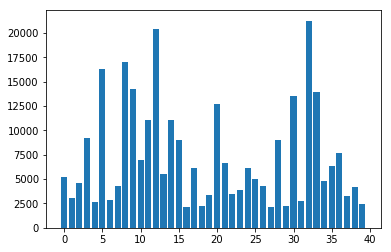

Visualize images of training generator, a quick check to see that input data is still sane:


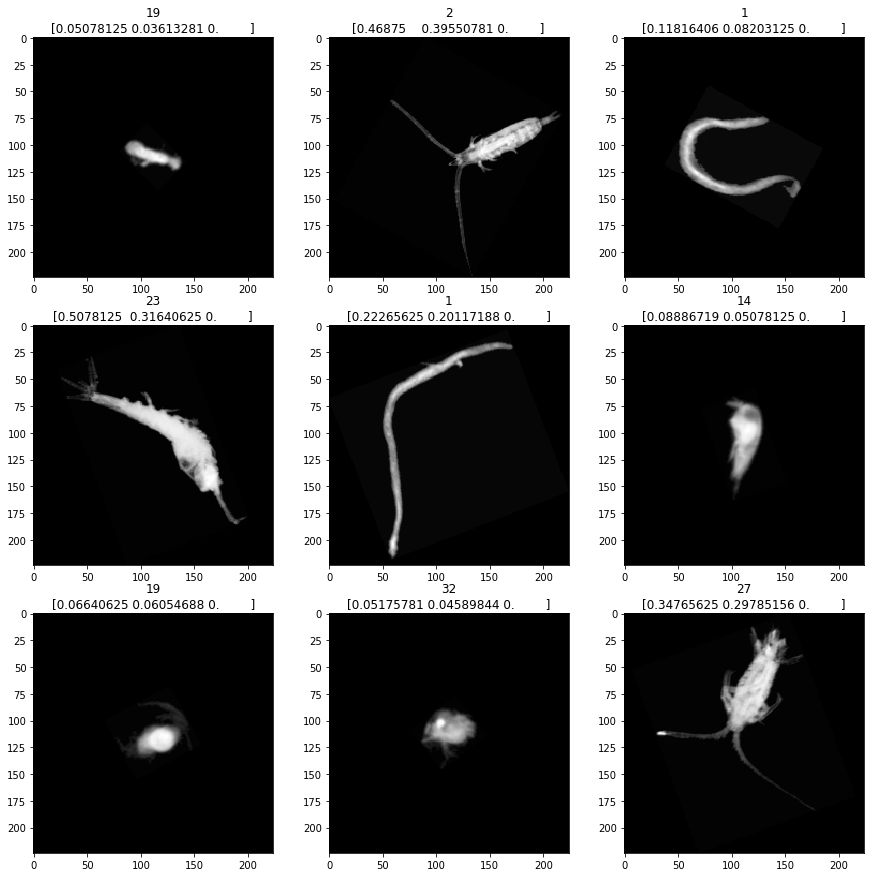

Visualize images of validation generator, a quick check to see that input data is still sane:


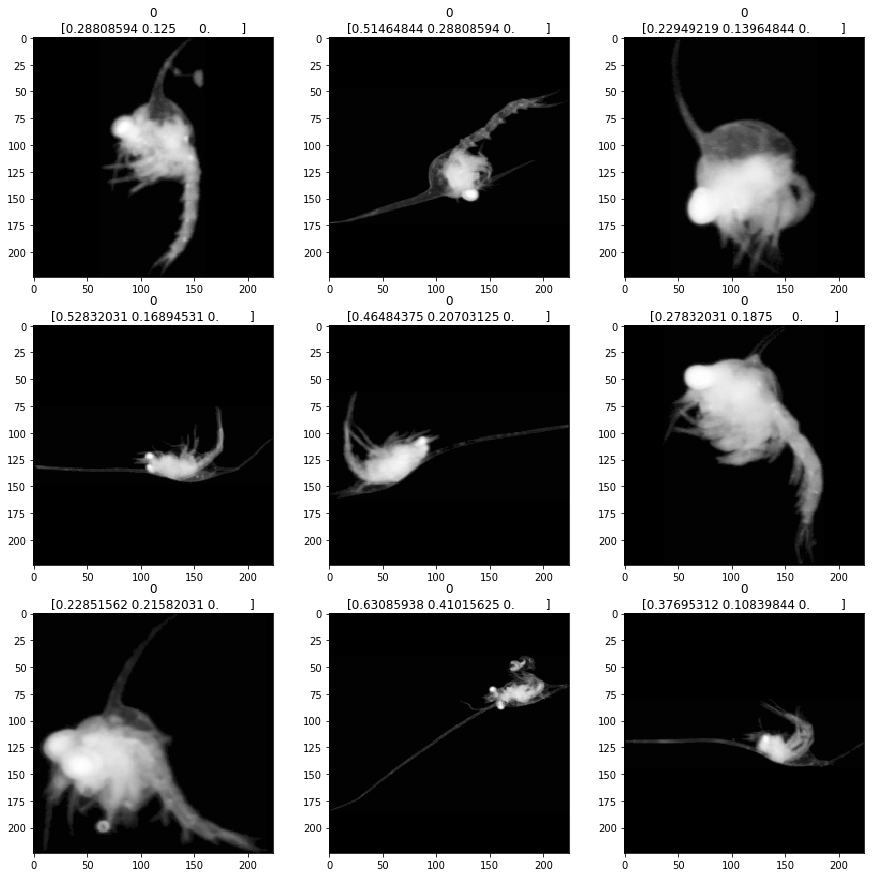

In [9]:
BATCH_SIZE = 8
dategen = MyGenerators(imgfolder, batch_size=BATCH_SIZE, val_fac=0.1)
train_gen = dategen.training_generator()
validation_gen = dategen.validation_generator()
NUMBER_LABELS = dategen.number_labels
visualize_generator(dategen)

Then lets add a helper function to train and save models:

In [25]:
def fit_and_save_model(name, model, train_gen, validation_gen, 
                       steps_per_epoch = 10, validation_steps=10, epochs=10, img_input=True, patience=10, load_old_weights=False):
    modeloutputfolder = os.path.join(outputfolder, name)
    if not os.path.exists(modeloutputfolder):
        os.makedirs(modeloutputfolder)
        
    if load_old_weights and os.path.exists(os.path.join(modeloutputfolder,'model_fitted.h5')):
        model = load_model(os.path.join(modeloutputfolder,'model_fitted.h5'))
    
    cbs=[ModelCheckpoint(filepath=os.path.join(modeloutputfolder,'model_fitted.h5'), verbose=1, save_best_only=True),
         EarlyStopping(monitor='val_loss', patience=patience),
         CSVLogger(os.path.join(modeloutputfolder,'model_history.csv'), separator=',', append=False)]
         
    start_time = time.time()
    history = model.fit_generator(train_gen,
                             steps_per_epoch=steps_per_epoch,
                             validation_data=validation_gen,
                             validation_steps=validation_steps,
                             epochs=epochs, 
                             callbacks=cbs,
                             verbose=1,
                             use_multiprocessing=True,
                             workers=5)
    end_time = time.time()
    
    model.load_weights(os.path.join(modeloutputfolder,'model_fitted.h5'))
    
    
    plot_model(model, 
           to_file=os.path.join(modeloutputfolder,'model_visualized.png'),
           show_shapes=True,
           show_layer_names=True)
    
    print("It has the following training history:")
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training data loss')
    plt.plot(history.history['val_loss'], label='Validation data loss')
    plt.legend()
    plt.title("Loss")
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['acc'], label='Training data accuracy')
    plt.plot(history.history['val_acc'], label='Validation data accuracy')
    plt.legend()
    plt.title("Accuracy")
    plt.suptitle("Model performance - {}".format(name))
    
    plt.savefig(os.path.join(modeloutputfolder,'model_history.png'))
    plt.show()
    
    score = model.evaluate_generator(validation_gen, steps=validation_steps)
    print("It has the following performance:")
    summary = "Validation loss: {}\nValidation accuracy: {}\nTraining time: {}".format(score[0], score[1], end_time-start_time)
    print(summary)
    
    with open(os.path.join(modeloutputfolder,'model_score.txt'), 'w+') as f:
        f.write(summary)

    print("It has the following confusion matrix:")
    img_vals = []
    stat_vals = []
    y_vals = []
    for i in range(validation_steps):
        x, y = validation_gen[i]
        if len(x) == 2:
            img_vals.append(x[0])
            stat_vals.append(x[1])
        else:
            img_vals.append(x)
        y_vals.append(y)
    if stat_vals:
        X_validation = [np.concatenate(img_vals), np.concatenate(stat_vals)]
    else:
        X_validation = [np.concatenate(img_vals)]
    y_target = np.concatenate(y_vals)
    y_predicted = np.argmax(model.predict(X_validation), axis= 1)
    y_true = np.argmax(y_target, axis= 1)
    cm = confusion_matrix(y_true, y_predicted)
    for i in range(len(cm)):
        cm[i,i] = 0
    plt.figure(figsize=(15,15))
    plt.imshow(cm, cmap="Greys")
    plt.xticks(range(max(y_true+1)))
    plt.yticks(range(max(y_true+1)))
    plt.title("Confusion matrix")
    plt.xlabel("True label")
    plt.ylabel("Predicted label")
    plt.savefig(os.path.join(modeloutputfolder,'model_confusion_matrix.png'))
    plt.show()
    
    if img_input:
        print("These are examples of misclassified features:")
        plt.figure(figsize=(15,15))
        plt.suptitle("Misclassified images - Model")
        poss_indexes = np.argwhere(y_predicted-y_true != 0)
        indexes = poss_indexes[np.random.choice(len(poss_indexes), 9)]

        for i, index in enumerate(indexes.ravel()):
            plt.subplot(3, 3, i+1)
            plt.imshow(X_validation[0][index].reshape(224,224), cmap="Greys_r")
            plt.title("A {} misclassified as {}".format(y_true[index], y_predicted[index]))
        plt.savefig(os.path.join(modeloutputfolder,'model_misclassified_features.png'))
        plt.show()

First lets define a simple convolutional network. Note that Ihave not been able to get batch normalization to work. I think I have this problem: https://github.com/keras-team/keras/issues/6973

In [17]:
inputs_image_simple_convolutional = Input(shape=(224,224,1))

x1 = Conv2D(32, (3, 3), input_shape=(224, 224, 1), activation='relu')(inputs_image_simple_convolutional)
#x1 = BatchNormalization()(x1)  
x1 = MaxPooling2D(pool_size=(2, 2))(x1)
x1 = Dropout(0.1)(x1)

x2 = Conv2D(48, (3, 3), padding='same', activation='relu')(x1)
#x2 = BatchNormalization()(x2)
x2 = MaxPooling2D(pool_size=(2, 2))(x2)
x2 = Dropout(0.1)(x2)

x3 = Conv2D(64, (3, 3), padding='same', activation='relu')(x2)
#x3 = BatchNormalization()(x3)
x3 = MaxPooling2D(pool_size=(2, 2))(x3)
x3 = Dropout(0.1)(x3)
x3 = Flatten()(x3)
outputs_image_simple_convolutional = Dense(512, activation='relu')(x3)

predictions_image_simple_convolutional = Dense(NUMBER_LABELS, activation='softmax', name="output")(outputs_image_simple_convolutional)
simple_convolutional = Model(inputs=inputs_image_simple_convolutional, outputs=predictions_image_simple_convolutional)
simple_convolutional.compile(optimizer='rmsprop', loss="categorical_crossentropy", metrics=["accuracy"])

Then lets train the model:

Epoch 1/50
1051/1051 [==============================] - 99s 94ms/step - loss: 2.6189 - acc: 0.2425 - val_loss: 2.2420 - val_acc: 0.3219

Epoch 00001: val_loss improved from inf to 2.24196, saving model to ../output/simple_convolutional/model_fitted.h5
Epoch 2/50
1051/1051 [==============================] - 97s 92ms/step - loss: 2.0416 - acc: 0.3842 - val_loss: 2.0859 - val_acc: 0.4002

Epoch 00002: val_loss improved from 2.24196 to 2.08592, saving model to ../output/simple_convolutional/model_fitted.h5
Epoch 3/50
1051/1051 [==============================] - 98s 93ms/step - loss: 1.9367 - acc: 0.4211 - val_loss: 1.9757 - val_acc: 0.4118

Epoch 00003: val_loss improved from 2.08592 to 1.97573, saving model to ../output/simple_convolutional/model_fitted.h5
Epoch 4/50
1051/1051 [==============================] - 100s 95ms/step - loss: 1.8474 - acc: 0.4474 - val_loss: 1.8763 - val_acc: 0.4437

Epoch 00004: val_loss improved from 1.97573 to 1.87627, saving model to ../output/simple_convoluti

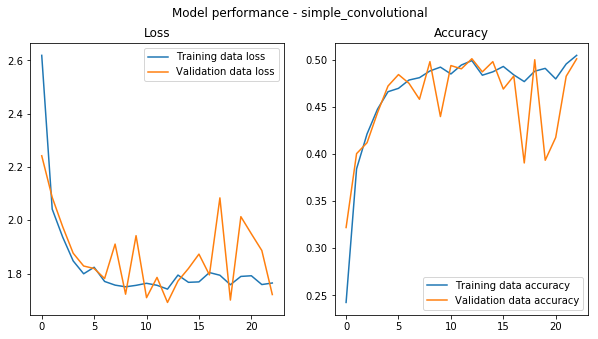

It has the following performance:
Validation loss: 1.691406422307094
Validation accuracy: 0.5008333333333334
Training time: 2281.2038407325745
It has the following confusion matrix:


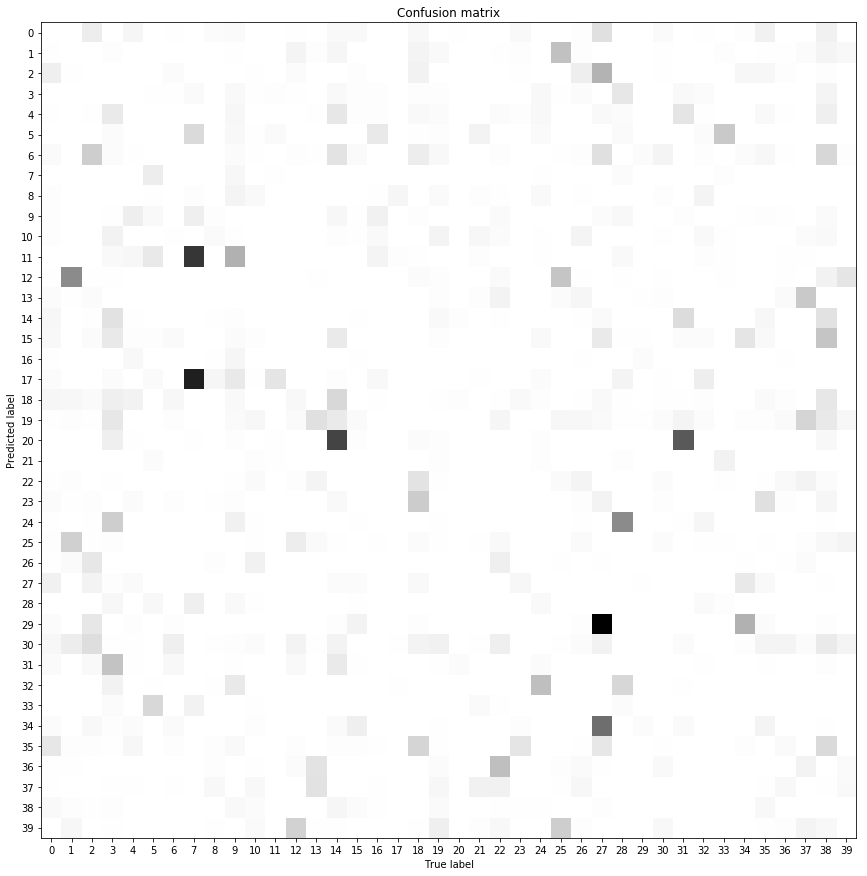

These are examples of misclassified features:


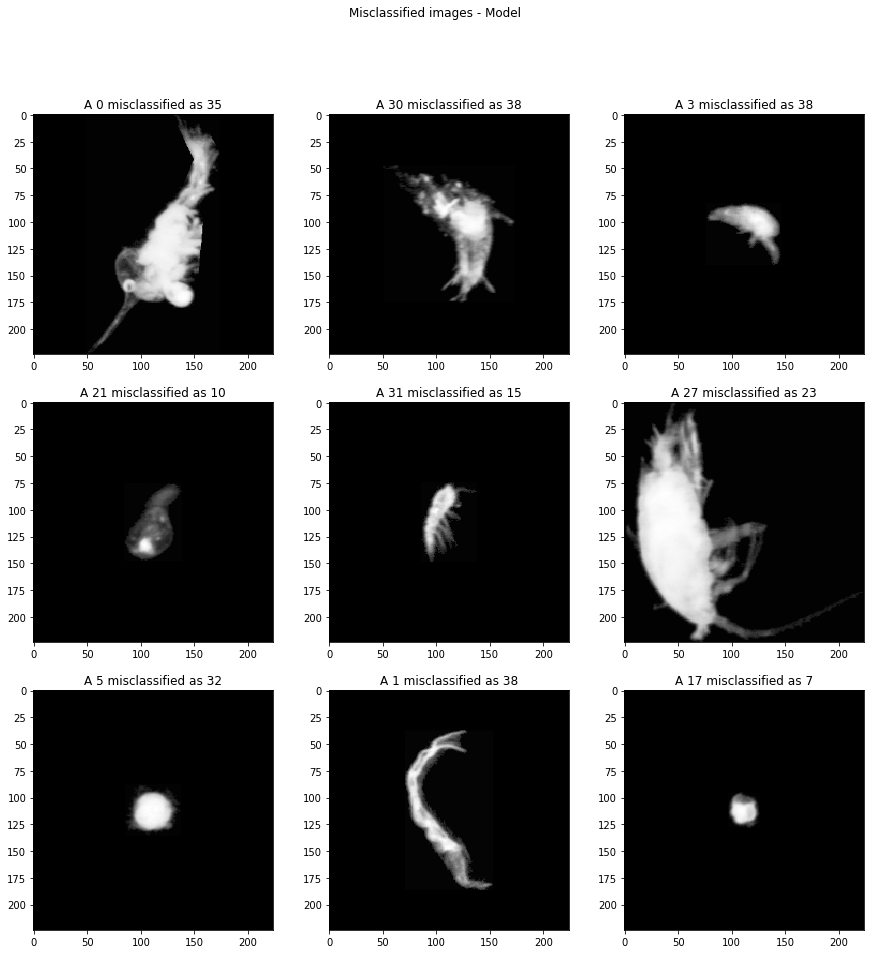

In [18]:
dategen = MyImageGenerators(imgfolder, batch_size=8, val_fac=0.1)
image_train_gen = dategen.training_generator()
image_validation_gen = dategen.validation_generator()
fit_and_save_model("simple_convolutional", simple_convolutional, image_train_gen, image_validation_gen,
                  steps_per_epoch = len(image_train_gen)//8, validation_steps=len(validation_gen), patience=10, epochs=50)

Not to bad... But not to impressive either... Clearly the network isnt overtraining though; the accuracy score on both the training and the validation data is about the same. An accuracy of about 50% on a balanced validation set including all the 40 classes is not to bad. Maybe the simple convolutional network defined above isn't complex enough to capture the variability of the data, or maybe there is to much overlap in the morphology of the plankton to greatly improve upon the score. From the model history curve it is clear that training the model longer won't help much. Lets continue investigating by defining a neural network that only considers trivial statistics (image width, image height, and relative object size) of the input image that isn't captured by the convolutional network.

In [19]:
inputs_stat = Input(shape=(3,))
x = Dense(16, activation='relu')(inputs_stat)
output_stat = Dense(NUMBER_LABELS, activation='relu')(x)
predictions_stat = Dense(NUMBER_LABELS, activation='softmax', name="output")(output_stat)
model_stat = Model(inputs=inputs_stat, outputs=predictions_stat)
model_stat.compile(optimizer='rmsprop', loss="categorical_crossentropy", metrics=["accuracy"])

And train it:

Epoch 1/50
1051/1051 [==============================] - 25s 24ms/step - loss: 3.5050 - acc: 0.0507 - val_loss: 3.2734 - val_acc: 0.0718

Epoch 00001: val_loss improved from inf to 3.27338, saving model to ../output/model_stat/model_fitted.h5
Epoch 2/50
1051/1051 [==============================] - 24s 23ms/step - loss: 3.1722 - acc: 0.0854 - val_loss: 3.1036 - val_acc: 0.0931

Epoch 00002: val_loss improved from 3.27338 to 3.10358, saving model to ../output/model_stat/model_fitted.h5
Epoch 3/50
1051/1051 [==============================] - 25s 24ms/step - loss: 3.0794 - acc: 0.0955 - val_loss: 3.0613 - val_acc: 0.0801

Epoch 00003: val_loss improved from 3.10358 to 3.06127, saving model to ../output/model_stat/model_fitted.h5
Epoch 4/50
1051/1051 [==============================] - 24s 23ms/step - loss: 3.0581 - acc: 0.1044 - val_loss: 3.0490 - val_acc: 0.0967

Epoch 00004: val_loss improved from 3.06127 to 3.04901, saving model to ../output/model_stat/model_fitted.h5
Epoch 5/50
1051/1051

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.309427). Check your callbacks.
  % delta_t_median)


1051/1051 [==============================] - 21s 20ms/step - loss: 2.8642 - acc: 0.1452 - val_loss: 2.8869 - val_acc: 0.1431

Epoch 00047: val_loss did not improve from 2.87393
Epoch 48/50
1051/1051 [==============================] - 21s 20ms/step - loss: 2.8784 - acc: 0.1415 - val_loss: 2.8828 - val_acc: 0.1511

Epoch 00048: val_loss did not improve from 2.87393
Epoch 49/50
1051/1051 [==============================] - 22s 21ms/step - loss: 2.8649 - acc: 0.1488 - val_loss: 2.8869 - val_acc: 0.1519

Epoch 00049: val_loss did not improve from 2.87393
Epoch 50/50
1051/1051 [==============================] - 22s 21ms/step - loss: 2.8646 - acc: 0.1600 - val_loss: 2.8776 - val_acc: 0.1420

Epoch 00050: val_loss did not improve from 2.87393
It has the following training history:


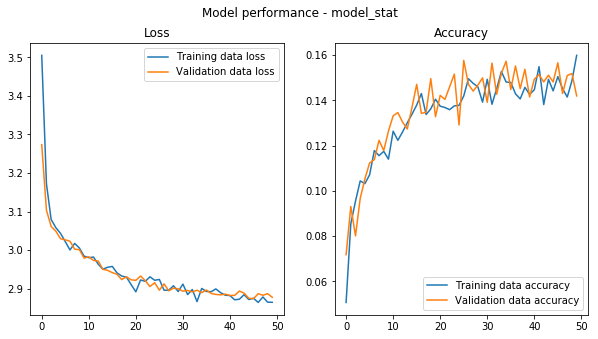

It has the following performance:
Validation loss: 2.8739271337645396
Validation accuracy: 0.15666666666666668
Training time: 1125.7765028476715
It has the following confusion matrix:


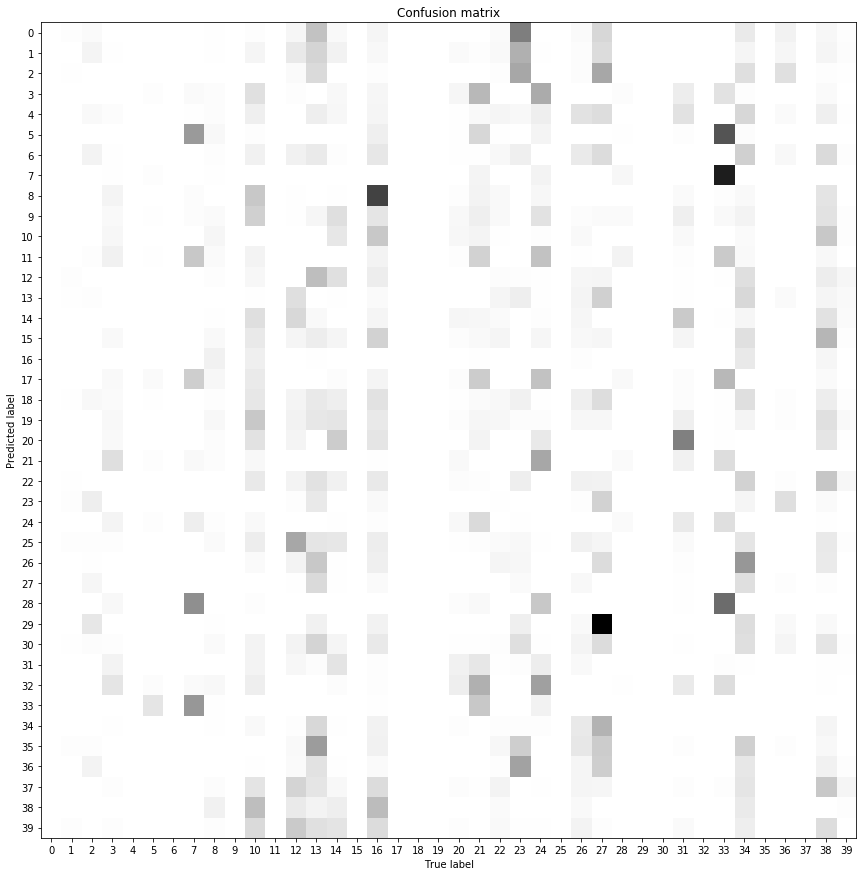

In [20]:
dategen = MyStatGenerators(imgfolder, batch_size=BATCH_SIZE, val_fac=0.1)
stat_train_gen = dategen.training_generator()
stat_validation_gen = dategen.validation_generator()

fit_and_save_model("model_stat", model_stat, stat_train_gen, stat_validation_gen,
                  steps_per_epoch = len(stat_train_gen)//8, validation_steps=len(validation_gen), patience=10, epochs=50, img_input=False) #100

Considering the simple input (image width, image height, and relative object size) a validation score of about 15% on a balanced validation set including all 40 classes is ok. I don't think there is much room to do much better than this without letting the network know more about the object it is classifying. Lets define a composite neural network that takes both the image statistics and the image itself as input:

In [21]:
x = Concatenate()([outputs_image_simple_convolutional, output_stat])
predictions_simple_composite = Dense(NUMBER_LABELS, activation='softmax', name="output")(x)

simple_composite_model = Model(inputs=[inputs_image_simple_convolutional, inputs_stat], outputs=predictions_simple_composite)

simple_composite_model.compile(optimizer='rmsprop', loss="categorical_crossentropy", metrics=["accuracy"])

And train it:

Epoch 1/50
1051/1051 [==============================] - 99s 94ms/step - loss: 2.2132 - acc: 0.3701 - val_loss: 1.8132 - val_acc: 0.4693

Epoch 00001: val_loss improved from inf to 1.81315, saving model to ../output/simple_composite_model/model_fitted.h5
Epoch 2/50
1051/1051 [==============================] - 105s 99ms/step - loss: 1.7853 - acc: 0.4731 - val_loss: 1.6625 - val_acc: 0.5088

Epoch 00002: val_loss improved from 1.81315 to 1.66248, saving model to ../output/simple_composite_model/model_fitted.h5
Epoch 3/50
1051/1051 [==============================] - 97s 92ms/step - loss: 1.7129 - acc: 0.4989 - val_loss: 1.7241 - val_acc: 0.4951

Epoch 00003: val_loss did not improve from 1.66248
Epoch 4/50
1051/1051 [==============================] - 99s 94ms/step - loss: 1.6981 - acc: 0.5112 - val_loss: 1.7248 - val_acc: 0.4835

Epoch 00004: val_loss did not improve from 1.66248
Epoch 5/50
1051/1051 [==============================] - 97s 93ms/step - loss: 1.6797 - acc: 0.5088 - val_loss: 

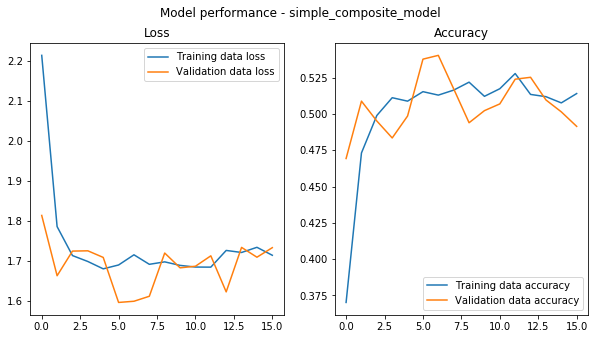

It has the following performance:
Validation loss: 1.595724414924071
Validation accuracy: 0.5377380952380952
Training time: 1593.2463557720184
It has the following confusion matrix:


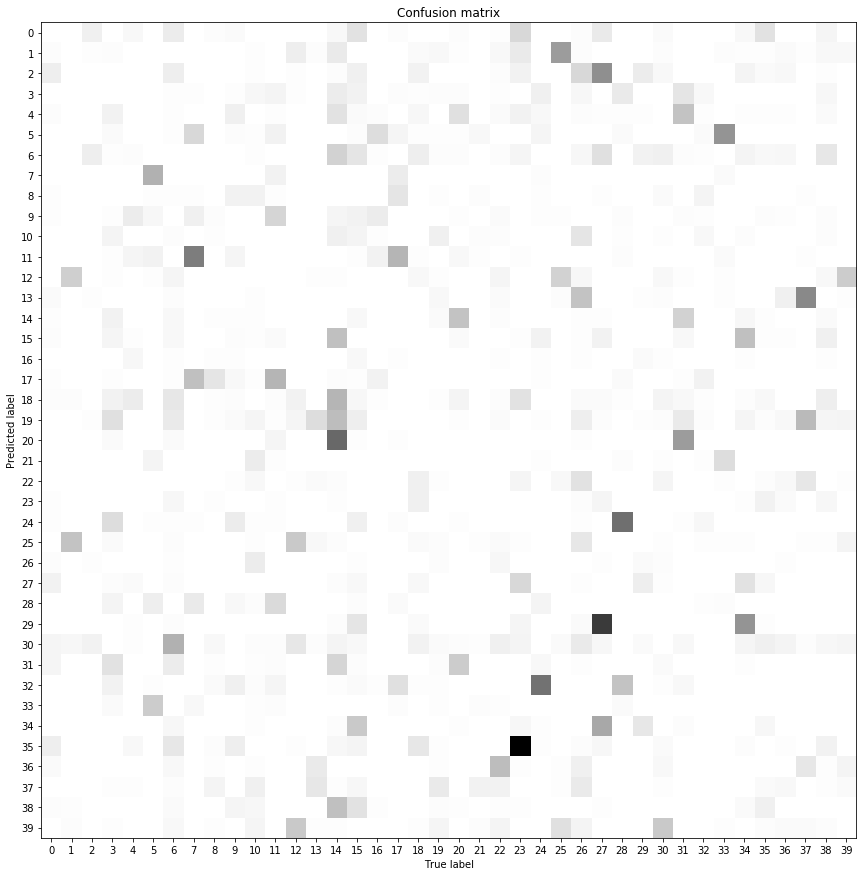

These are examples of misclassified features:


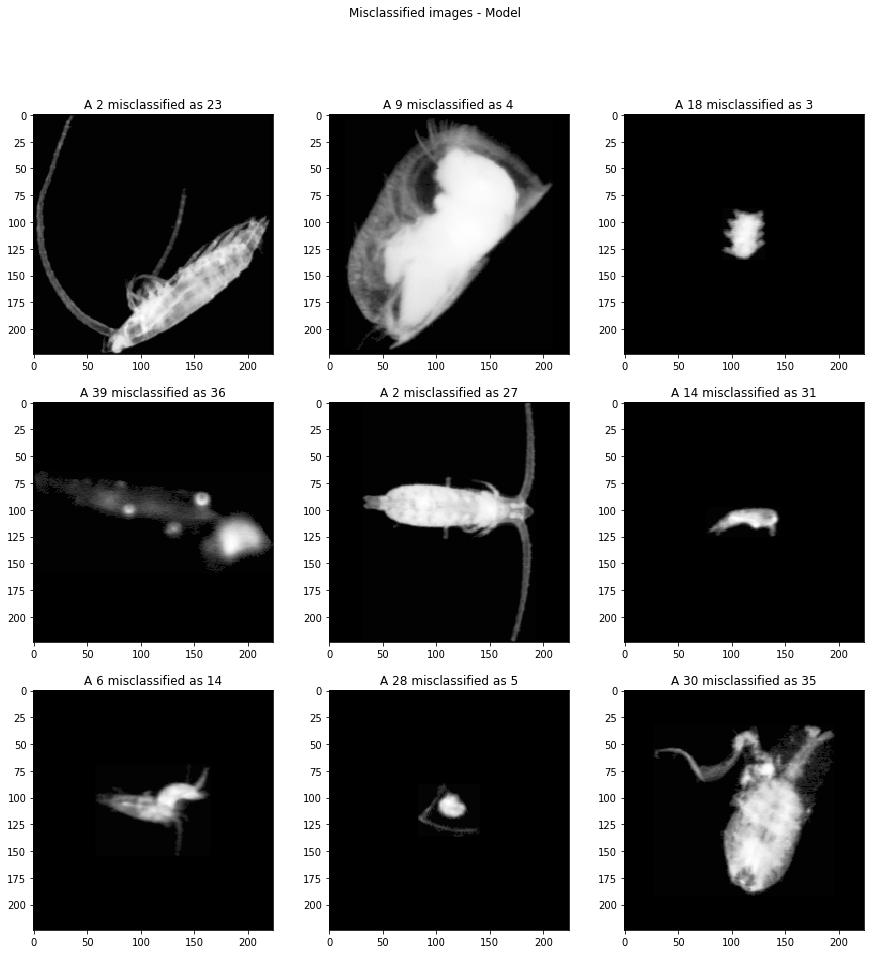

In [22]:
fit_and_save_model("simple_composite_model", simple_composite_model, train_gen, validation_gen,
                  steps_per_epoch = len(train_gen)//8, validation_steps=len(validation_gen), patience=10, epochs=50)

Arghh... That didn't improve the accuracy of the models a lot! Lets try to make the composite model a little bit more complex by adding a dense layer and see if that improves the accuracy:

In [23]:
x = Concatenate()([outputs_image_simple_convolutional, output_stat])
x = Dense(1024, activation='relu')(x)
predictions_less_simple_composite = Dense(NUMBER_LABELS, activation='softmax', name="output")(x)

less_simple_composite_model = Model(inputs=[inputs_image_simple_convolutional, inputs_stat], outputs=predictions_less_simple_composite)

less_simple_composite_model.compile(optimizer='rmsprop', loss="categorical_crossentropy", metrics=["accuracy"])

Training it:

In [2]:
#fit_and_save_model("less_simple_composite_model", less_simple_composite_model, train_gen, validation_gen,
#                  steps_per_epoch = len(train_gen)//8, validation_steps=len(validation_gen), patience=10, epochs=50)

I lost the output, however this model did as well as the simple composite model trained above. So no improvement in adding an additional dense layer.

Well... That wasn't much of an improvement either... Lets try a new approach using transfer learning with a pretrained model. I chose to use the MobileNetV2 model with the top removed. This architecture is among the smallest included in keras, and consequently I hope that it is easiest and fastest to train. I set the pretrained model as trainable and add a small dense layer on the top. If the problem with the simple convolutional model above was that it wasn't complex enough then surely this architecture should fare better.

In [7]:
pretrained_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224,224,3))
pretrained_model.trainable = True

inputs_image_make_multi_dimensional = Input(shape=(224,224,1))
make_multi_dimensional = Conv2D(3, kernel_size=(3,3), padding='same', activation='relu')(inputs_image_make_multi_dimensional)
x = pretrained_model(make_multi_dimensional)
x = Flatten()(x)
outputs_pretrained = Dense(256, activation='relu')(x)

predictions_pretrained = Dense(NUMBER_LABELS, activation='softmax', name="output")(outputs_pretrained)
model_transfer_learning = Model(inputs=inputs_image_make_multi_dimensional, outputs=predictions_pretrained)
model_transfer_learning.compile(optimizer='rmsprop', loss="categorical_crossentropy", metrics=["accuracy"])

Lets train it:

In [1]:
dategen = MyImageGenerators(imgfolder, batch_size=BATCH_SIZE, val_fac=0.1)
image_train_gen = dategen.training_generator()
image_validation_gen = dategen.validation_generator()
fit_and_save_model("model_transfer_learning", model_transfer_learning, image_train_gen, image_validation_gen,
                  steps_per_epoch = len(image_train_gen)//8, validation_steps=len(validation_gen), patience=3, epochs=3) #20

Didn't manage to train this model in a jupyter notebook. Here is its output:
<img src="../output/model_transfer_learning_pretrained_notfixed/model_history.png">
It took 24 minutes to train. Clearly the model is massively overtrained! No use at all...


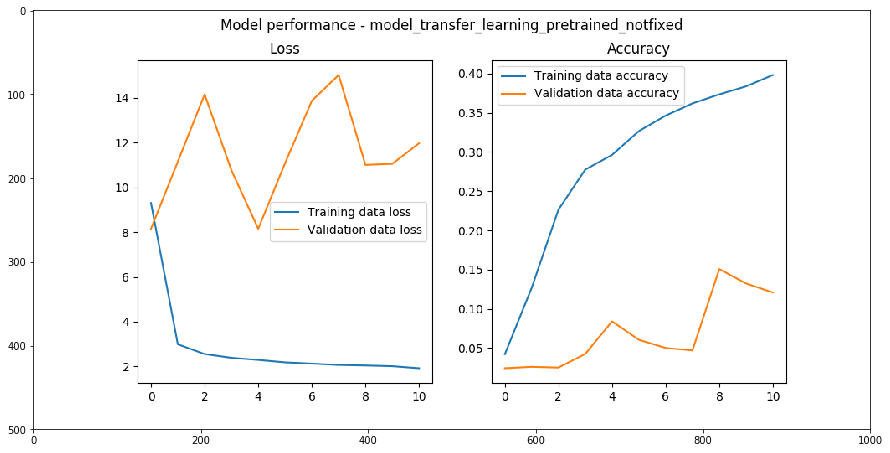

In [4]:
from skimage import io
import matplotlib.pyplot as plt
im = io.imread('../output/model_transfer_learning_pretrained_notfixed/model_history.png')
plt.figure(figsize=(15,15))
plt.imshow(im)
plt.show()

In conclusion, a simple convolutional network was able to give an accuracy of 50% on the training data. Making a composite model that also took some image statistics didn't really improve upon this. Trying to train the dataset on MobileNetV2 network did not work at all... Unsure why.